<h1 align="center">
    Players Analysis in SQL and Python
</h1>

<h3 align="center">
    By: Shreeyasha Pandey
</h3>

---

## ☰ Project Overview

This project explores trends and patterns within a Major League Baseball (MLB) player dataset using SQL for data extraction and Python for analysis and visualization.

The analysis focuses on player performance, salary distributions, and position-based trends to uncover key insights relevant for stakeholders such as recruiters, coaches, or sports data analysts.

- **Tools:** PostgreSQL, Python (pandas, matplotlib, seaborn), Jupyter Notebook
- **Topics Covered:** Position breakdowns, salary trends, performance metrics

---

## ☰ Dataset Summary

The data is stored in a PostgreSQL relational database containing tables such as:

- `players`: Biographical information of each MLB player
- `salaries`: Yearly salary records by player and team
- `schools`: School and year attended by player
- `schools_details`: School info (name, city, state, country)

We’ll use SQL to extract and filter relevant slices of the data throughout the notebook.

---


## ☰ Table of Contents
1. [Libraries and Database Setup](#1-libraries-and-database-setup)
2. [Loading the Dataset](#2-loading-the-dataset)
3. [School Analysis](#3-school-analysis)
4. [Concluding Summary](#4-concluding-summary)

---

## 1. Libraries and Database Setup <a class="anchor" id="1-libraries-and-database-setup"></a>

### Import Libraries

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# Environment Variables and DB Connection
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine

# Set global seaborn styles
sns.set_style("white", {"axes.spines.right": False, "axes.spines.top": False, 
                            "axes.spines.left": True,"axes.spines.bottom": True})

### Create Database Engine

In [9]:
# Load from .env file
load_dotenv()

# Fetch credentials from environment
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST", "localhost")
DB_PORT = os.getenv("DB_PORT", "5432")

# Create SQLAlchemy engine
engine = create_engine(f'postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')

---
## 2. Loading the Dataset <a class="anchor" id="loading-the-dataset"></a>
The following section loads all necessary tables from the PostgreSQL database using SQL queries. Each table is previewed to give a sense of its structure and content.


In [11]:
def load_table(table_name):
    """Load a table from the database into a pandas DataFrame."""
    query = f"SELECT * FROM {table_name};"
    return pd.read_sql(query, con=engine)

In [12]:
# Load the tables
players = load_table("players")
salaries = load_table("salaries")
school_details = load_table("school_details")
schools = load_table("schools")

Next, we'll define a small helper function that formats and displays the first and last few rows of a DataFrame. This allows us to get a quick sense of the table's structure and content throughout the analysis.

In [14]:
def preview_table(df, table_name, n=2):
    """Preview the first and last few rows of a DataFrame with ellipsis in between."""
    ellipsis_row = pd.DataFrame({col: '...' for col in df.columns}, index=['...'])
    
    display(Markdown(f"**Preview of `{table_name}`:**"))
    preview_df = pd.concat([df.head(n), ellipsis_row, df.tail(n)])
    display(preview_df)

---
## 3. School-Based Analysis

In this section, we analyze the role of educational institutions in producing Major League Baseball (MLB) players. Using data from the `schools` and `school_details` tables, we aim to explore patterns in player origins based on schools, states, and time periods. 

In [16]:
# Preview the tables
preview_table(schools, "schools")
preview_table(school_details, "school_details")

**Preview of `schools`:**

,playerid,schoolid,yearid
0,aardsda01,pennst,2001
1,aardsda01,rice,2002
...,...,...,...
17348,zuvelpa01,stanford,1979
17349,zuvelpa01,stanford,1980


**Preview of `school_details`:**

,schoolid,name_full,city,state,country
0,abilchrist,Abilene Christian University,Abilene,TX,USA
1,adelphi,Adelphi University,Garden City,NY,USA
...,...,...,...,...,...
1205,yale,Yale University,New Haven,CT,USA
1206,youngst,Youngstown State University,Youngstown,OH,USA


### 📑 Section Goals:
The following key questions will guide our analysis:

1. **Top Player-Producing Schools:**  
   Identify the top 5 schools that have produced the largest number of MLB players.

2. **Geographic Distribution:**  
   Analyze the locations of these schools — specifically, the states they are based in — to understand regional trends.

3. **Trends in Schools Influence to MLB Talent:**  
   For each decade, determine how many unique schools produced MLB players. This helps capture the breadth of institutions involved across different eras.

4. **Top MLB Producers by Decade:**  
   Identify the top 3 schools that produced the most players in each decade. This will highlight how school influence may have shifted over time.

This analysis will help uncover historical and regional influences in player development and could potentially inform scouting strategies or historical retrospectives.

### 3.1 Top Player-Producing Schools

***SQL Query:***
```sql
SELECT sd.name_full AS school_name, s.players_produced
FROM school_details AS sd
RIGHT JOIN (
	SELECT schoolid, COUNT(DISTINCT playerid) AS players_produced
	FROM schools
	GROUP BY schoolid) AS s
ON sd.schoolid = s.schoolid
ORDER BY s.players_produced DESC
LIMIT 5;


***Query Result:***

In [20]:
# Hidden query execution
query = """
    SELECT sd.name_full AS school_name, s.players_produced
    FROM school_details AS sd
    RIGHT JOIN (
    	SELECT schoolid, COUNT(DISTINCT playerid) AS players_produced
    	FROM schools
    	GROUP BY schoolid) AS s
    ON sd.schoolid = s.schoolid
    ORDER BY s.players_produced DESC
    LIMIT 5;
"""

In [21]:
# Run query and preview result
df_top_five_schools = pd.read_sql(query, con=engine)
df_top_five_schools

,school_name,players_produced
0,University of Texas at Austin,107
1,University of Southern California,105
2,Arizona State University,101
3,Stanford University,86
4,University of Michigan,76


**💡 Insights:**

These schools stand out as major talent pipelines for Major League Baseball, with UT Austin and USC leading the list.

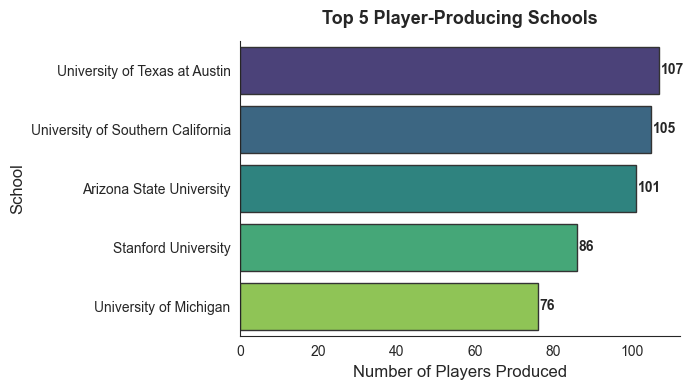

In [23]:
plt.figure(figsize=(7, 4))
sns.barplot(data=df_top_five_schools, x="players_produced", y="school_name",
            hue="school_name", palette="viridis", edgecolor=".2")

# Add bar labels
for index, value in enumerate(df_top_five_schools["players_produced"]):
    plt.text(value + 0.5, index, str(value), va='center', fontsize=10, fontweight='semibold')

# Axis labels & title
plt.xlabel("Number of Players Produced", fontsize=12)
plt.ylabel("School", fontsize=12)
plt.title("Top 5 Player-Producing Schools", fontsize=13, weight='bold', pad=12)

plt.tight_layout()
plt.show()

---
### 3.2 Geographic Distribution
In this section, we analyze the geographic distribution of MLB players based on the states where they attended school. The goal is to identify which states have historically produced the highest number of professional baseball players.

***SQL Query:***
```sql
SELECT sd.state, COUNT(DISTINCT playerid) AS num_players
FROM schools AS s
LEFT JOIN school_details AS sd
ON s.schoolid = sd.schoolid
GROUP BY sd.state
ORDER BY num_players DESC
LIMIT 3;

***Query Result:***

In [26]:
# Hidden query execution
query = """
    SELECT sd.state, COUNT(DISTINCT playerid) AS num_players
    FROM schools AS s
    LEFT JOIN school_details AS sd
    ON s.schoolid = sd.schoolid
    GROUP BY sd.state
    ORDER BY num_players DESC
    LIMIT 3;
"""

In [27]:
# Run query and preview result
df_top_three_states = pd.read_sql(query, con=engine)
df_top_three_states

,state,num_players
0,CA,1247
1,TX,536
2,FL,473


**💡 Insights:**

California stands out as the top contributor for producing MLB players (1,247), with Texas (536) and Florida (473) trailing behind. The substantial gap suggests California as a stronger baseball pipeline.

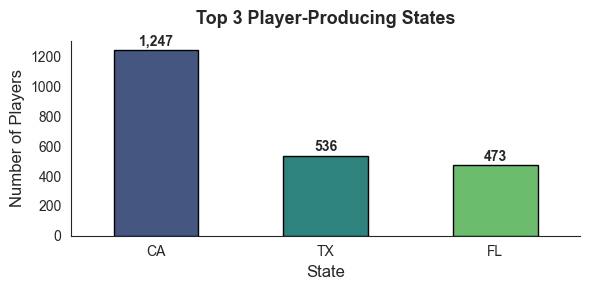

In [29]:
plt.figure(figsize=(6, 3))
sns.barplot(data=df_top_three_states, x="state", y="num_players",
            hue='state', palette="viridis", 
            edgecolor="black", width=0.5)

# Annotate bars
for index, value in enumerate(df_top_three_states["num_players"]):
    plt.text(x=index, y=value + 10, s=f"{value:,}", ha="center", va="bottom", fontsize=10, weight='bold')

# Axis & title
plt.title("Top 3 Player-Producing States", fontsize=13, weight='bold', pad=12)
plt.xlabel("State", fontsize=12)
plt.ylabel("Number of Players", fontsize=12)

plt.tight_layout()
plt.show()

---
### 3.3 Trends in Schools Influence to MLB Talent
We now examine how the number of unique schools contributing MLB players has changed across decades. This helps highlight how the talent pipeline has expanded or concentrated over time.

***SQL Query:***
```sql
SELECT FLOOR(yearid/10) * 10 AS decade, COUNT(DISTINCT schoolid) AS num_schools
FROM schools
GROUP BY decade
ORDER BY decade;

***Query Result:***

In [32]:
# Hidden query execution
query = """
    SELECT FLOOR(yearid/10) * 10 AS decade, COUNT(DISTINCT schoolid) AS num_schools
    FROM schools
    GROUP BY decade
    ORDER BY decade;
"""

In [33]:
# Run query and preview result
df_school_decades = pd.read_sql(query, con=engine)
preview_table(df_school_decades, "df_school_decades")

**Preview of `df_school_decades`:**

,decade,num_schools
0,1860.0,2
1,1870.0,14
...,...,...
14,2000.0,372
15,2010.0,57


**💡 Insights:**

- From the 1860s through the early 20th century, there was a **steady rise** in the number of schools contributing players to Major League Baseball.
  
- The trend **accelerated sharply** beginning in the 1960s, reaching a peak in the 1990s with nearly 500 schools represented.

- After the 1990s, there is a **notable decline** in the number of contributing schools. It is possible that fewer schools now produce more players.

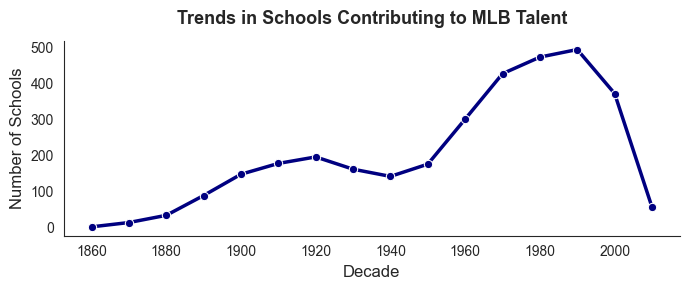

In [35]:
plt.figure(figsize=(7, 3))
sns.lineplot(data=df_school_decades, x="decade", y="num_schools", marker='o', linewidth=2.5, color='navy')

# Axis and Title
plt.title("Trends in Schools Contributing to MLB Talent", fontsize=13, weight='bold', pad=12)
plt.xlabel("Decade", fontsize=12)
plt.ylabel("Number of Schools", fontsize=12)

plt.tight_layout()
plt.show()

---
### 3.4 Top MLB Producers by Decade
In this section, we examine how the **most influential schools in producing MLB players** have changed over time. By grouping data by decade and identifying the top school for each, we can explore shifts in talent pipelines and institutional influence throughout baseball history.

***SQL Query:***
```sql
WITH school_by_decade AS (
	 SELECT *, FLOOR(yearid/10) * 10 AS decade
	 FROM schools
	 ORDER BY decade
),
school_ranking AS (
	 SELECT decade, schoolid, COUNT(DISTINCT playerid) AS num_players,
			ROW_NUMBER() OVER (PARTITION BY decade ORDER BY COUNT(DISTINCT playerid) DESC) AS school_rank
	 FROM school_by_decade
	 GROUP BY decade, schoolid
)

SELECT CONCAT(sr.decade, 's') AS decade, 
	   sd.name_full AS school_name, sr.num_players AS num_players
FROM school_ranking AS sr
LEFT JOIN school_details AS sd ON sr.schoolid = sd.schoolid
WHERE school_rank =1
ORDER BY sr.decade DESC;

***Query Result:***

In [38]:
# Hidden query execution
query = """
WITH school_by_decade AS (
	 SELECT *, FLOOR(yearid/10) * 10 AS decade
	 FROM schools
	 ORDER BY decade
),
school_ranking AS (
	 SELECT decade, schoolid, COUNT(DISTINCT playerid) AS num_players,
			ROW_NUMBER() OVER (PARTITION BY decade ORDER BY COUNT(DISTINCT playerid) DESC) AS school_rank
	 FROM school_by_decade
	 GROUP BY decade, schoolid
)

SELECT CONCAT(sr.decade, 's') AS decade, 
	   sd.name_full AS school_name, sr.num_players AS num_players
FROM school_ranking AS sr
LEFT JOIN school_details AS sd ON sr.schoolid = sd.schoolid
WHERE school_rank =1
ORDER BY sr.decade DESC;
"""

In [39]:
# Run query and preview result
df_top_school_by_decade = pd.read_sql(query, con=engine)
preview_table(df_top_school_by_decade, "df_top_school_by_decade")

**Preview of `df_top_school_by_decade`:**

,decade,school_name,num_players
0,2010s,University of Florida,5
1,2000s,Arizona State University,23
...,...,...,...
14,1870s,Brown University,3
15,1860s,Fordham University,1


**💡 Insights:**

- **Arizona State University** stands out as a **dominant contributor** to MLB player production during the mid-to-late 20th century, topping the 1960s, 1970s, and 2000s.
- The University of Southern California also had a strong presence in the mid-1900s.
- In earlier decades, elite Northeastern schools such as Yale, Brown, and Fordham led the way, highlighting a historical shift in talent pipelines from the Northeast to the West and South over time.

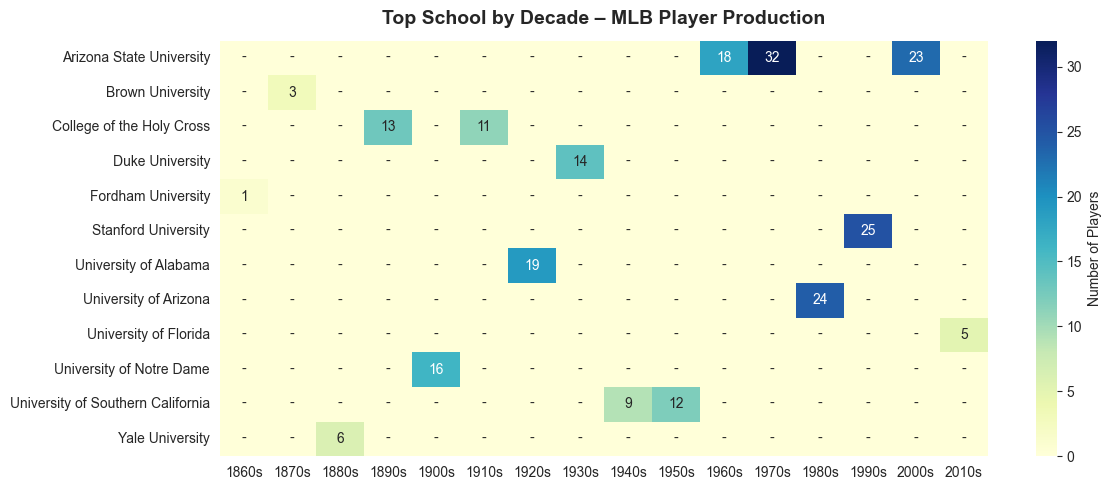

In [41]:
# Pivot the data to create a matrix of schools (rows) vs. decades (columns)
heatmap_df = df_top_school_by_decade.pivot_table(index="school_name", columns="decade", 
                                                 values="num_players", fill_value=0)
heatmap_df = heatmap_df.astype(int)

# Create a heatmap to show player production across decades
plt.figure(figsize=(12, 5))
sns.heatmap(heatmap_df, annot=heatmap_df.copy().replace(0, '-'), fmt='', cmap="YlGnBu", cbar_kws={'label': 'Number of Players'})

plt.title("Top School by Decade – MLB Player Production", fontsize=14, weight='bold', pad=12)
plt.xlabel("")
plt.ylabel("")

plt.tight_layout()
plt.show()

---
## 4. Salary Analysis
In this section, we explore the salary landscape across MLB teams to uncover spending patterns and financial dominance over time.

In [43]:
preview_table(salaries, "salaries")

**Preview of `salaries`:**

,yearid,teamid,lgid,playerid,salary
0,1985,ATL,NL,barkele01,870000
1,1985,ATL,NL,bedrost01,550000
...,...,...,...,...,...
24756,2014,WAS,NL,zimmejo02,7500000
24757,2014,WAS,NL,zimmery01,14000000


### 📑 Section Goals:

1. **Top 20% High-Spending Teams:**  
   Identify the top 20% of teams based on their average annual salary spending, revealing the most financially aggressive franchises.

2. **Cumulative Spending Over Time:**  
   Track the cumulative salary expenditure for each team across seasons, providing insights into long-term strategies.

3. **Threshold of \$1 Billion Cumulative Spend:**  
   Determine the first year each team’s cumulative salary surpassed \$1 billion, spotlighting franchises with sustained high spending over time.

This investigation sheds light on how financial investments vary across franchises and how long-term spending correlates with broader league dynamics.

### 4.1 Top 20% High-Spending Teams
This gives insight into which franchises have consistently invested the most in player compensation over the years.

***SQL Query:***
```sql
-- Calculate total salary spending per year for each team
CREATE TEMPORARY TABLE IF NOT EXISTS team_annual AS (
	SELECT teamid, yearid, SUM(salary) AS total_spend_yr
	FROM salaries
	GROUP BY teamid, yearid
	ORDER BY teamid, yearid);

-- Segment teams into quintiles and compute average yearly spending
WITH avg_spend_tiles AS (
	SELECT teamid,
			AVG(total_spend_yr) AS avg_yearly_spend,
			NTILE(5) OVER (ORDER BY ROUND(AVG(total_spend_yr)) DESC) AS spend_pct 
	FROM team_annual
	GROUP BY teamid)

-- Extract the top quintile (top 20%)
SELECT teamid as team, ROUND(avg_yearly_spend / 1000000, 1) AS avg_spend_in_mil
FROM avg_spend_tiles
WHERE spend_pct = 1;

***Query Result:***

In [47]:
# Hidden query execution
query = """
CREATE TEMPORARY TABLE IF NOT EXISTS team_annual AS (
	SELECT teamid, yearid, SUM(salary) AS total_spend_yr
	FROM salaries
	GROUP BY teamid, yearid
	ORDER BY teamid, yearid);

WITH avg_spend_tiles AS (
	SELECT teamid,
			AVG(total_spend_yr) AS avg_yearly_spend,
			NTILE(5) OVER (ORDER BY ROUND(AVG(total_spend_yr)) DESC) AS spend_pct
	FROM team_annual
	GROUP BY teamid)

SELECT teamid AS team, ROUND(avg_yearly_spend / 1000000, 1) AS avg_spend_in_mil
FROM avg_spend_tiles
WHERE spend_pct = 1;
"""

In [48]:
# Run query and preview result
df_top_20_pct = pd.read_sql(query, con=engine)
df_top_20_pct

,team,avg_spend_in_mil
0,SFG,143.5
1,LAA,118.5
2,NYA,109.4
3,BOS,81.1
4,LAN,74.6
5,WAS,71.5
6,ARI,71.2
7,PHI,66.1


**💡 Insights:**

Among the top 20% of MLB teams, the **San Francisco Giants (SFG)** lead by a significant margin with an average of **$143.5 million**, followed by the **Los Angeles Angels (LAA)** and **New York Yankees (NYA)**. These high-spending teams likely have greater financial resources and a strong focus on attracting top talent through lucrative contracts.

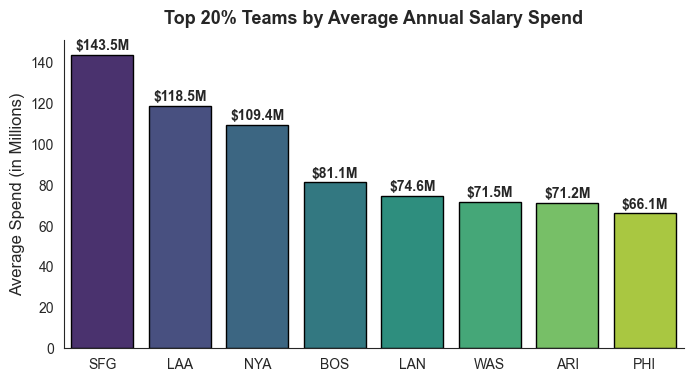

In [50]:
plt.figure(figsize=(8, 4))
sns.barplot(data=df_top_20_pct, x='team', y='avg_spend_in_mil', hue='team', palette='viridis', edgecolor='black')

# Add value labels
for index, value in enumerate(df_top_20_pct["avg_spend_in_mil"]):
    plt.text(x=index, y=value + 1, s=f"${value:.1f}M", ha='center', va="bottom", fontsize=10, weight='bold')
    
# Title and labels
plt.title('Top 20% Teams by Average Annual Salary Spend', fontsize=13, fontweight='bold', pad=12)
plt.xlabel('')
plt.ylabel('Average Spend (in Millions)', fontsize=12)

plt.show()

---
### 4.2 Cumulative Spending Over Time

***SQL Query:***
```sql
-- Calculate each team's cumulative salary spending over the years (in millions)
SELECT teamid AS team, yearid AS year, 
	   ROUND(SUM(total_spend_yr) OVER 
	   (PARTITION BY teamid ORDER BY yearid) / 1000000, 1) AS cumulative_sum_in_mil
FROM team_annual
ORDER BY teamid, yearid;

***Query Result:***

In [53]:
# Hidden Query Execution
query = """
WITH team_annual AS (
    SELECT teamid, yearid, SUM(salary) AS total_spend_yr
    FROM salaries
    GROUP BY teamid, yearid
)

SELECT teamid AS team, yearid AS year, 
       ROUND(SUM(total_spend_yr) OVER 
             (PARTITION BY teamid ORDER BY yearid) / 1000000, 1) AS cumulative_sum_in_mil
FROM team_annual
ORDER BY teamid, yearid;
"""

In [54]:
df_team_cumulative_spend = pd.read_sql(query, con=engine)
preview_table(df_team_cumulative_spend, "df_team_cumulative_spend")

**Preview of `df_team_cumulative_spend`:**

,team,year,cumulative_sum_in_mil
0,ANA,1997,31.1
1,ANA,1998,72.4
...,...,...,...
858,WAS,2013,583.4
859,WAS,2014,715.4


**💡 Insights:**

The **New York Yankees (NYA)** have led cumulative salary spending, with a sharp takeoff starting in the 2000s that sets them apart from the rest. **Boston Red Sox (BOS), Los Angeles Dodgers (LAN)**, and **New York Mets (NYN)** follow behind with relatively similar trajectories. In contrast, the **Philadelphia Phillies (PHI)** show a more gradual and steady rise in cumulative salary spending, with fewer fluctuations over the years. This reflects differing financial strategies and team-building philosophies across franchises.

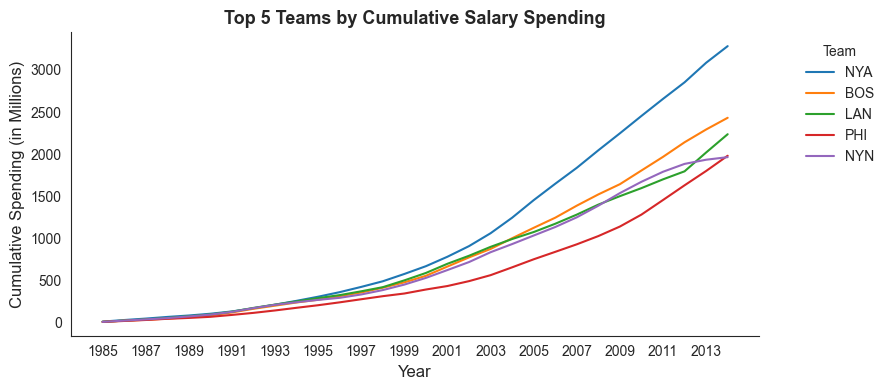

In [56]:
# Get cumulative salary for each team
team_salary_cum = salaries.pivot_table(values='salary', index='teamid', aggfunc='sum').sort_values(ascending=False, by='salary')

# Filter top 5 teams
top_teams = team_salary_cum.head(5).index.values
filtered_df = df_team_cumulative_spend[df_team_cumulative_spend['team'].isin(top_teams)]

# Stacked Line plot
plt.figure(figsize=(9, 4))
sns.lineplot(data=filtered_df, x='year', y='cumulative_sum_in_mil', hue='team', hue_order=top_teams, palette='tab10')
plt.title('Top 5 Teams by Cumulative Salary Spending', fontweight='bold', fontsize=13)
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left', edgecolor='white')
plt.ylabel('Cumulative Spending (in Millions)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(range(filtered_df['year'].min(), filtered_df['year'].max(), 2))

plt.tight_layout()
plt.show()

---
### 4.3 Threshold of \$1 Billion Cumulative Spend:
This section identifies the first year in which each team’s cumulative total spending exceeds $1 billion.

***SQL Query:***
```sql
-- Calculate cumulative spend (in millions) per team across years
WITH team_cumulative AS (
	SELECT teamid, yearid, 
			ROUND(SUM(total_spend_yr) OVER 
			(PARTITION BY teamid ORDER BY yearid) / 1000000, 1) AS cumulative_sum_in_mil
	FROM team_annual
),
-- Identify the first year each team crosses $1 billion cumulative spend
year_ranking AS (
	SELECT *, FIRST_VALUE(yearid) OVER (PARTITION BY teamid ORDER BY yearid) AS yr_1_bil
	FROM team_cumulative
	WHERE cumulative_sum_in_mil > 1000
	ORDER BY teamid, yearid)
    
-- Extract the year where each team hit the $1B threshold
SELECT teamid, yr_1_bil, ROUND(cumulative_sum_in_mil / 1000, 2) AS cumulative_sum_in_bil
FROM year_ranking
WHERE yearid = yr_1_bil;

***Query Result:***

In [59]:
# Hidden Query Execution
query = """
WITH team_annual AS (
    SELECT teamid, yearid, SUM(salary) AS total_spend_yr
    FROM salaries
    GROUP BY teamid, yearid
),
team_cumulative AS (
	SELECT teamid, yearid, 
			ROUND(SUM(total_spend_yr) OVER 
			(PARTITION BY teamid ORDER BY yearid) / 1000000, 1) AS cumulative_sum_in_mil
	FROM team_annual
),
year_ranking AS (
	SELECT *, FIRST_VALUE(yearid) OVER (PARTITION BY teamid ORDER BY yearid) AS yr_1_bil
	FROM team_cumulative
	WHERE cumulative_sum_in_mil > 1000
	ORDER BY teamid, yearid)

SELECT teamid, yr_1_bil, ROUND(cumulative_sum_in_mil / 1000, 2) AS cumulative_sum_in_bil
FROM year_ranking
WHERE yearid = yr_1_bil;
"""

In [60]:
df_one_bil_threshold = pd.read_sql(query, con=engine)
preview_table(df_one_bil_threshold, "df_one_bil_threshold")

**Preview of `df_one_bil_threshold`:**

,teamid,yr_1_bil,cumulative_sum_in_bil
0,ARI,2012,1.02
1,ATL,2005,1.07
...,...,...,...
24,TEX,2007,1.04
25,TOR,2008,1.05


We calculate the frequency distribution of the years when each team first surpassed $1 billion in cumulative spend.
Additionally, we identify and visualize the earliest teams (by 2007) to reach this threshold.

**Frequency Distribution of Teams Reaching $1 Billion:**

In [63]:
# Calculate frequency of first $1B milestones by year
df_year_count = df_one_bil_threshold['yr_1_bil'].value_counts().sort_index()

**Earliest Teams to Reach $1 Billion (By 2007):**

In [65]:
# Identify early spenders
early_spenders = df_one_bil_threshold[df_one_bil_threshold['yr_1_bil'] <= 2007]
early_spenders_jittered = early_spenders.copy()

# Apply small manual y-offsets to overlapping points
overlapping_teams = ['SEA', 'SFN', 'TEX']
offsets = [-0.002, 0, 0.002]  # Slight manual jitter
for team, offset in zip(overlapping_teams, offsets):
    early_spenders_jittered.loc[early_spenders_jittered['teamid'] == team, 'cumulative_sum_in_bil'] += offset

**💡 Insights:**
- **2007** stands out, with **6 teams** reaching their first \$1 billion in cumulative spend — the highest across all years.
- **2008** and **2012** each saw 4 teams crossing the mark.
- **2005** had **3 teams** achieving the milestone.

- **NYA (New York Yankees)** became the **first team** to cross \$1 billion, achieving it in **2003** with a cumulative spend of **\$1.06 billion**.
- **BOS (Boston Red Sox)** followed in **2004**, hitting exactly \$1.00 billion.

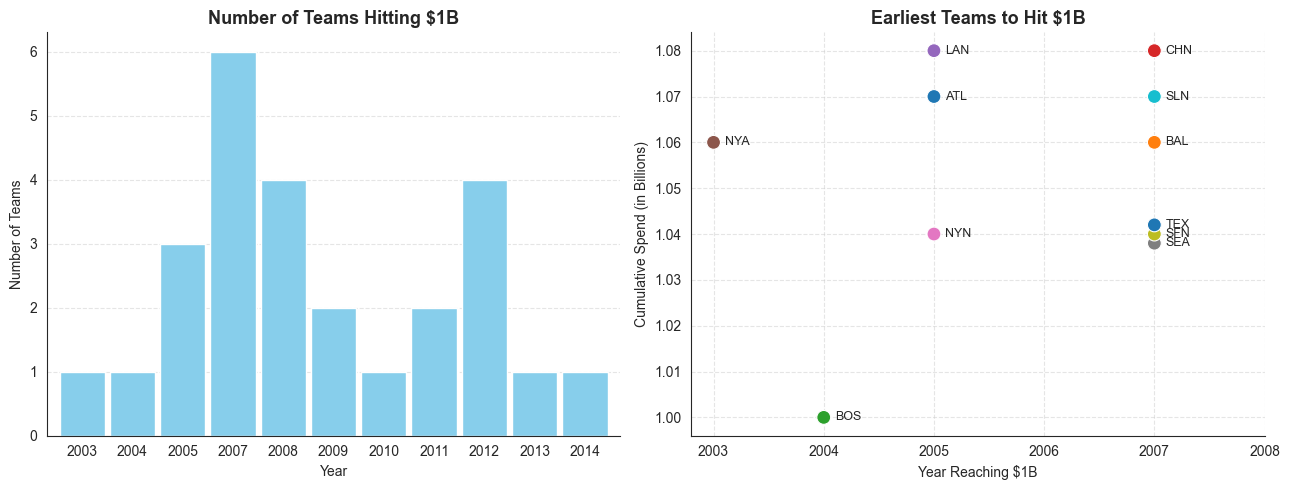

In [67]:
# Set up side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(13, 5))  # 1 row, 2 columns

# --- Left: Bar Plot (Frequency Distribution) ---
df_year_count.plot.bar(
    color='skyblue', 
    width=0.9, 
    ax=axes[0]
)

axes[0].set_title('Number of Teams Hitting $1B', fontweight='bold', fontsize=13)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Teams')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# --- Right: Scatter Plot (Earliest Teams) ---
ax2 = axes[1]
sns.scatterplot(
    data=early_spenders_jittered, 
    x='yr_1_bil', 
    y='cumulative_sum_in_bil', 
    hue='teamid', 
    palette='tab10', 
    s=100,
    legend=False,
    ax=ax2
)

# Add labels to each scatter point
for i in range(early_spenders_jittered.shape[0]):
    ax2.text(
        early_spenders_jittered['yr_1_bil'].iloc[i] + 0.1,
        early_spenders_jittered['cumulative_sum_in_bil'].iloc[i],
        early_spenders_jittered['teamid'].iloc[i],
        fontsize=9,
        ha='left',
        va='center'
    )

ax2.set_title('Earliest Teams to Hit $1B', fontweight='bold', fontsize=13)
ax2.set_xlabel('Year Reaching $1B')
ax2.set_ylabel('Cumulative Spend (in Billions)')
ax2.set_xticks(range(2003, 2009, 1))
ax2.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

---
## 4. Career Analysis
In this section, we explore the career history of MLB players.

### 📑 Section Goals
We aim to answer the following questions:

- **4.1 Initial Player Overview:**  
   View key career fields: `playerid`, `birthyear`, `namegiven`, `debut`, `finalgame`, and total number of players.

-  **4.2 Career Span Analysis:**  
   Analyze career length: How long did players' careers last? At what age did they debut and retire?

-  **4.3 Team History Exploration:**  
   Identify teams played by each player over time, focusing on first and last teams. Find players who started and ended their career on the same team and played for over a decade.

### 4.1 Initial Player Overview

In [70]:
players_subset = players[['playerid', 'birthyear', 'birthmonth', 'birthday', 'namegiven', 'debut', 'finalgame']]
preview_table(players_subset, "players_subset")

**Preview of `players_subset`:**

,playerid,birthyear,birthmonth,birthday,namegiven,debut,finalgame
0,aardsda01,1981.0,12.0,27.0,David Allan,2004-04-06,2013-09-28
1,aaronha01,1934.0,2.0,5.0,Henry Louis,1954-04-13,1976-10-03
...,...,...,...,...,...,...,...
18587,zuverge01,1924.0,8.0,20.0,George,1951-04-21,1959-06-15
18588,zwilldu01,1888.0,11.0,2.0,Edward Harrison,1910-08-14,1916-07-12


In [71]:
players_subset['playerid'].nunique()

18589

There are 18,589 players present in the table.

---
### 4.2 Career Span Analysis:
In this section, we examine how long players' careers lasted, along with their debut and retirement ages.

***SQL Query:***
```sql
-- Create a temporary table with additional career fields
CREATE TEMPORARY TABLE IF NOT EXISTS career_info AS (
    SELECT playerid, birthyear, birthmonth, birthday, namegiven, debut, finalgame, 
           EXTRACT(YEAR FROM debut) AS debut_year,
           EXTRACT(YEAR FROM finalgame) AS final_year
    FROM players
);

-- Calculate career length, debut age, and retirement age
SELECT playerid, namegiven, 
       final_year - debut_year AS career_length,
       debut_year - birthyear AS start_age,
       final_year - birthyear AS end_age
FROM career_info
WHERE final_year - debut_year IS NOT NULL AND debut_year - birthyear > 0
ORDER BY career_length DESC;

***Query Result:***

In [75]:
# Hidden Query Execution
query = """
CREATE TEMPORARY TABLE IF NOT EXISTS career_info AS (
	SELECT playerid, birthyear, birthmonth, birthday, namegiven, debut, finalgame, 
			EXTRACT(YEAR FROM debut) AS debut_year,
			EXTRACT(YEAR FROM finalgame) AS final_year
	FROM players);
	
SELECT playerid, namegiven, final_year - debut_year AS career_length,
		debut_year - birthyear AS start_age,
		final_year - birthyear AS end_age
FROM career_info
WHERE final_year - debut_year IS NOT NULL AND debut_year - birthyear > 0
ORDER BY career_length DESC;
"""

In [76]:
df_career_span  = pd.read_sql(query, con=engine)
preview_table(df_career_span, "df_career_span")

**Preview of `df_career_span`:**

,playerid,namegiven,career_length,start_age,end_age
0,altroni01,Nicholas,35.0,22.0,57.0
1,orourji01,James Henry,32.0,22.0,54.0
...,...,...,...,...,...
18256,zinsebi01,William Francis,0.0,26.0,26.0
18257,zoccope01,Peter Jude,0.0,26.0,26.0


### Insights:


**Quick Descriptive Statistics:**

In [79]:
# Get basic statistics for career_length, start_age, and end_age
df_career_span[['career_length', 'start_age', 'end_age']].describe()

,career_length,start_age,end_age
count,18258.000000,18258.000000,18258.000000
mean,4.750137,24.303976,29.054113
std,5.026937,2.805492,4.902201
min,0.000000,16.000000,16.000000
25%,0.000000,22.000000,26.000000
50%,3.000000,24.000000,28.000000
75%,8.000000,26.000000,32.000000
max,35.000000,42.000000,59.000000


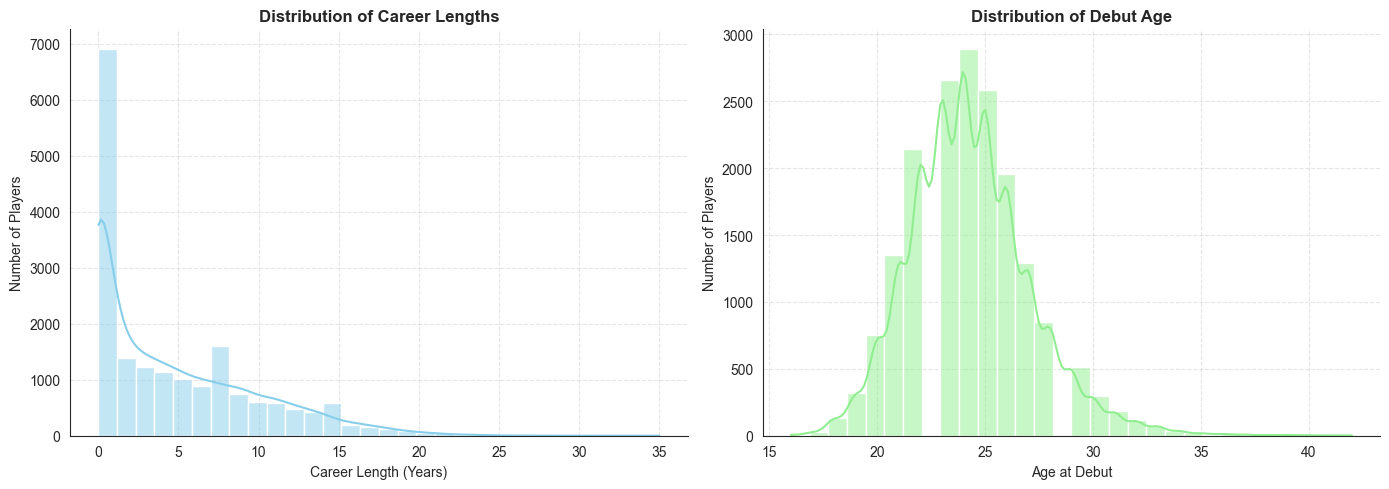

In [80]:
# Get basic statistics for career_length, start_age, and end_age
df_career_span[['career_length', 'start_age', 'end_age']].describe()# Side-by-side plots: Career Length and Debut Age Distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

# -- Career Length Distribution --
sns.histplot(df_career_span['career_length'], bins=30, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Distribution of Career Lengths', fontweight='bold')
axes[0].set_xlabel('Career Length (Years)')
axes[0].set_ylabel('Number of Players')
axes[0].grid(True, linestyle='--', alpha=0.5)

# -- Starting Age Distribution --
sns.histplot(df_career_span['start_age'], bins=30, kde=True, color='lightgreen', ax=axes[1])
axes[1].set_title('Distribution of Debut Age', fontweight='bold')
axes[1].set_xlabel('Age at Debut')
axes[1].set_ylabel('Number of Players')
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### 🔍 Career Span Insights
**Average Career Length:**

- Players typically have a career span of **5 years.**
- While rare cases stretch up to **35 years**, the majority have much shorter careers with **75% of players spending 8 years or less** in professional play.
- Suprisingly, expectional number of players (almost 7,000) **ended their career in 1 year or less.**

**Debut and Retirement Ages:**

- Most players **debut around age 24** and **retire around age 29**.
- Some exceptional players debuted **as early as 16** or **as late as 42.**
- About **half the players** concluded their careers by age **28**.

---
### 4.3 Team History Exploration
In this section, we aim to answer what team each player started and ended their career with.
We also account for cases where a player's final recorded year in the database does not align perfectly with the salaries table (e.g., missing final year salary data).

***SQL Query:***
```sql
-- Player's Career Info
WITH career_info AS (
    SELECT playerid, birthyear, birthmonth, birthday, namegiven, debut, finalgame, 
           EXTRACT(YEAR FROM debut) AS debut_year,
           EXTRACT(YEAR FROM finalgame) AS final_year
    FROM players
)

-- Select the players' debut and final team information
SELECT *,
           FIRST_VALUE(teamid) OVER (PARTITION BY playerid ORDER BY yearid) AS debut_team,
           FIRST_VALUE(teamid) OVER (PARTITION BY playerid ORDER BY yearid DESC) AS final_team,
           ROW_NUMBER() OVER (PARTITION BY playerid ORDER BY yearid ASC) AS row_num
    FROM (
        SELECT ci.playerid, ci.namegiven, ci.debut_year, ci.final_year, s.yearid, s.teamid
        FROM career_info AS ci
        LEFT JOIN salaries AS s
          ON ci.playerid = s.playerid
        WHERE s.teamid IS NOT NULL
    )
    ORDER BY playerid, yearid;


***Query Result:***

In [84]:
query = """
WITH career_info AS (
    SELECT playerid, birthyear, birthmonth, birthday, namegiven, debut, finalgame, 
           EXTRACT(YEAR FROM debut) AS debut_year,
           EXTRACT(YEAR FROM finalgame) AS final_year
    FROM players
)
SELECT *,
           FIRST_VALUE(teamid) OVER (PARTITION BY playerid ORDER BY yearid) AS debut_team,
           FIRST_VALUE(teamid) OVER (PARTITION BY playerid ORDER BY yearid DESC) AS final_team,
           ROW_NUMBER() OVER (PARTITION BY playerid ORDER BY yearid ASC) AS row_num
    FROM (
        SELECT ci.playerid, ci.namegiven, ci.debut_year, ci.final_year, s.yearid, s.teamid
        FROM career_info AS ci
        LEFT JOIN salaries AS s
          ON ci.playerid = s.playerid
        WHERE s.teamid IS NOT NULL
    )
    ORDER BY playerid, yearid;
"""

In [87]:
df_team_history = pd.read_sql(query, con=engine)
preview_table(df_team_history, "df_team_history")

**Preview of `df_team_history`:**

,playerid,namegiven,debut_year,final_year,yearid,teamid,debut_team,final_team,row_num
0,aardsda01,David Allan,2004.0,2013.0,2004,SFN,SFN,NYA,1
1,aardsda01,David Allan,2004.0,2013.0,2007,CHA,SFN,NYA,2
...,...,...,...,...,...,...,...,...,...
24751,zupcibo01,Robert,1991.0,1994.0,1993,BOS,BOS,BOS,3
24752,zuvelpa01,Paul,1982.0,1991.0,1989,ATL,ATL,ATL,1


**Long Term Team Loyalty vs Movement:**

By identifying the debut team and final team for each player, we analyze how many players started and ended their career with the same teamcould indicate a high level of team loyalty.

- **Long-Term Loyalty:** Players who started and ended their career with the same team could indicate a high level of team loyalty.

- **Frequent Team Changes:** Players who switched teams often might suggest a higher degree of mobility or demand across different franchises.

In [90]:
bool_df = (df_team_history['row_num'] == 1) & (df_team_history['debut_team'] == df_team_history['final_team']) & (df_team_history['final_year'] - df_team_history['debut_year'] > 5)
bool_df.sum()

611

Out of 24,752 only 611 ended up in the same team as their debut and played with for more than 5 years in their career.

<Axes: xlabel='teamid'>

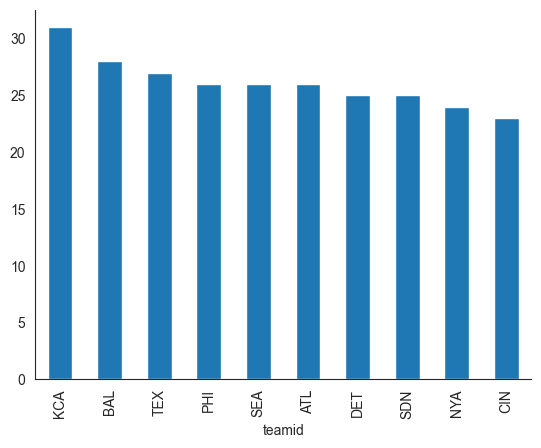

In [166]:
df_team_history.loc[bool_df, 'teamid'].value_counts().head(10).plot.bar()

Teams with Highest Player Retension: KCA (30), BAl (28), and TEX (27).

In [176]:
# Filter players who have played for 10 or more distinct teams
df_team_count = df_team_history.groupby('playerid')['teamid'].nunique()
df_team_count[df_team_count >= 10]

playerid
batismi01    10
blanche01    10
stairma01    11
Name: teamid, dtype: int64

Players with highest movement:


|batismi01 |   10 |
|----------|------|
|blanche01 |  10  |
|stairma01 |   11 |

---
## 5. Players Comparision Analysis
In this section, we compare players based on personal attributes and playing styles to uncover trends and similarities.
Let's view important player attributes such as weight, height, batting side (`bats`), throwing hand (`throws`), and birthday.

In [215]:
cols = ['playerid', 'namegiven', 'birthyear', 'birthmonth', 'birthday', 
        'weight', 'height', 'bats', 'throws','debut', 'finalgame']

preview_table(players[cols], "players_subset")

**Preview of `players_subset`:**

,playerid,namegiven,birthyear,birthmonth,birthday,weight,height,bats,throws,debut,finalgame
0,aardsda01,David Allan,1981.0,12.0,27.0,205.0,75.0,R,R,2004-04-06,2013-09-28
1,aaronha01,Henry Louis,1934.0,2.0,5.0,180.0,72.0,R,R,1954-04-13,1976-10-03
...,...,...,...,...,...,...,...,...,...,...,...
18587,zuverge01,George,1924.0,8.0,20.0,195.0,76.0,R,R,1951-04-21,1959-06-15
18588,zwilldu01,Edward Harrison,1888.0,11.0,2.0,160.0,66.0,L,L,1910-08-14,1916-07-12


In [555]:
display(players['bats'].unique())
display(players['throws'].unique())

array(['R', 'L', None, 'B'], dtype=object)

array(['R', 'L', None], dtype=object)

### 📑 Section Goals
We aim to answer the following questions:

-  **5.1 Age Group Analysis:**  
   Identify players of the same age and analyze common age groups across the player population.

-  **5.2 Batting and Throwing Preferences by Team:**  
   Create summary tables for each team showing the percentage of players who bat right, left, or both, and the same for throwing handedness.

-  **5.3 Height and Weight Trends Over Time:**  
   Analyze how average debut height and weight have changed over the years, and compare decade-over-decade differences.

### 5.1 Age Group Analysis
***SQL Query:***
```sql
WITH players_info AS (
SELECT playerid, namegiven, (birthyear || '-' || birthmonth || '-' || birthday)::DATE AS birthdate, 
		weight, height, bats, throws, debut, finalgame
FROM players
WHERE deathyear IS NULL),

-- Group by age group and with atleast 50 players within the age group
players_by_age_group AS (
	SELECT *, FLOOR(EXTRACT(YEAR FROM AGE(birthdate)) / 10) * 10 AS age_group
	FROM players_info
	WHERE birthdate IS NOT NULL)

SELECT age_group::INT AS age_group, COUNT(*) AS players_num
FROM players_by_age_group
GROUP BY age_group
ORDER BY players_num DESC;

***Query Result:***

In [403]:
## Hidden Query Execution
query = """
WITH players_info AS (
SELECT playerid, namegiven, (birthyear || '-' || birthmonth || '-' || birthday)::DATE AS birthdate, 
		weight, height, bats, throws, debut, finalgame
FROM players
WHERE deathyear IS NULL),

-- 2b. Group by age group and with atleast 50 players within the age group
players_by_age_group AS (
	SELECT *, FLOOR(EXTRACT(YEAR FROM AGE(birthdate)) / 10) * 10 AS age_group
	FROM players_info
	WHERE birthdate IS NOT NULL)

SELECT age_group::INT AS age_group, COUNT(*) AS players_num
FROM players_by_age_group
GROUP BY age_group
ORDER BY players_num DESC;
"""

In [405]:
df_players_ages = pd.read_sql(query2, con=engine)
preview_table(df_players_ages, "df_players_ages")

**Preview of `df_players_ages`:**

,age_group,players_num
0,40,2075
1,50,1868
...,...,...
10,150,7
11,170,4


<Axes: xlabel='age_group', ylabel='players_num'>

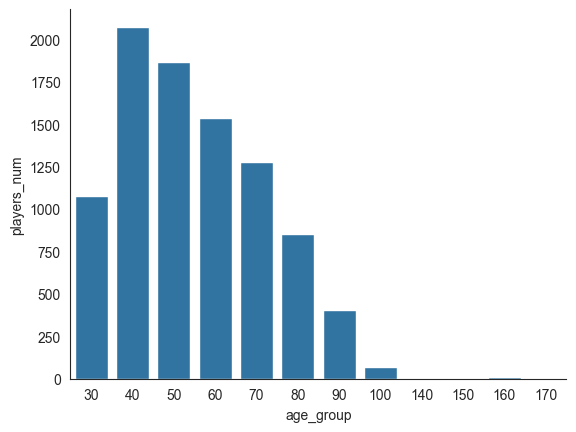

In [280]:
sns.barplot(data=df_players_ages, x='age_group', y='players_num')

---
### 5.2 Batting and Throwing Preferences by Team
***SQL Query:***

```sql
WITH sum_stats AS (
    SELECT 
        s.teamid,
        COUNT(DISTINCT CASE WHEN p.bats = 'B' THEN p.playerid ELSE NULL END) AS bat_both,
        COUNT(DISTINCT CASE WHEN p.bats = 'L' THEN p.playerid ELSE NULL END) AS bat_left,
        COUNT(DISTINCT CASE WHEN p.bats = 'R' THEN p.playerid ELSE NULL END) AS bat_right,
        COUNT(DISTINCT CASE WHEN p.throws = 'L' THEN p.playerid ELSE NULL END) AS throw_left,
        COUNT(DISTINCT CASE WHEN p.throws = 'R' THEN p.playerid ELSE NULL END) AS throw_right,
        COUNT(DISTINCT p.playerid) * 1.0 AS total
    FROM players AS p
    LEFT JOIN salaries AS s ON p.playerid = s.playerid
    WHERE teamid IS NOT NULL
    GROUP BY s.teamid
)

SELECT COALESCE(teamid, 'N/A') AS team,
		ROUND(bat_both/total * 100, 2) AS bat_both_pct,
		ROUND(bat_left/total * 100, 2) AS bat_left_pct,
		ROUND(bat_right/total * 100, 2) AS bat_right_pct,
		ROUND(throw_left/total * 100, 2) AS throw_left_pct,
		ROUND(throw_right/total * 100, 2) throw_right_pct
FROM sum_stats;

In [600]:
# Hidden Query Execution
query = """
WITH sum_stats AS (
    SELECT 
        s.teamid,
        COUNT(DISTINCT CASE WHEN p.bats = 'B' THEN p.playerid ELSE NULL END) AS bat_both,
        COUNT(DISTINCT CASE WHEN p.bats = 'L' THEN p.playerid ELSE NULL END) AS bat_left,
        COUNT(DISTINCT CASE WHEN p.bats = 'R' THEN p.playerid ELSE NULL END) AS bat_right,
        COUNT(DISTINCT CASE WHEN p.throws = 'L' THEN p.playerid ELSE NULL END) AS throw_left,
        COUNT(DISTINCT CASE WHEN p.throws = 'R' THEN p.playerid ELSE NULL END) AS throw_right,
        COUNT(DISTINCT p.playerid) * 1.0 AS total
    FROM players AS p
    LEFT JOIN salaries AS s ON p.playerid = s.playerid
    WHERE teamid IS NOT NULL
    GROUP BY s.teamid
)

SELECT COALESCE(teamid, 'N/A') AS team,
		ROUND(bat_both/total * 100, 2) AS bat_both_pct,
		ROUND(bat_left/total * 100, 2) AS bat_left_pct,
		ROUND(bat_right/total * 100, 2) AS bat_right_pct,
		ROUND(throw_left/total * 100, 2) AS throw_left_pct,
		ROUND(throw_right/total * 100, 2) throw_right_pct
FROM sum_stats;
"""

In [602]:
df_preference_stats = pd.read_sql(query, con=engine)
preview_table(df_preference_stats, "df_batting_stats")

**Preview of `df_batting_stats`:**

,team,bat_both_pct,bat_left_pct,bat_right_pct,throw_left_pct,throw_right_pct
0,ANA,9.09,24.55,66.36,17.27,82.73
1,ARI,9.01,29.61,61.37,21.89,78.11
...,...,...,...,...,...,...
35,TOR,9.25,25.37,65.37,18.81,81.19
36,WAS,10.43,28.22,61.35,21.47,78.53


In [604]:
df_preference_stats.describe().loc[['mean', 'max', '25%', '50%', '75%']]

,bat_both_pct,bat_left_pct,bat_right_pct,throw_left_pct,throw_right_pct
mean,9.494865,27.857027,62.647297,21.16027,78.84
max,18.520000,32.130000,68.600000,25.00000,87.50
25%,8.520000,26.960000,61.210000,20.06000,76.94
50%,9.350000,28.220000,63.020000,21.27000,78.73
75%,10.500000,29.170000,63.730000,23.06000,79.94


- Batting Preference across teams: Teams tend to have on average have 63% of players who prefer right-handed batting (with as much as 69% of team players preferring this style), with 28% preferring left, only 9% players preferring for both on average across teams.
- THrow preference across teams: An overwhelming 79% of players on team on average prefer right-handed throws and only 21% left on average show prefence for left. The majority (80%) of players on a team prefer the right throws 75% of the time or less.
So, we see much more variability in batting preference than throws.

In [687]:
# Separate into two DataFrames for Batting and Throwing
batting_df = df_preference_stats.set_index('team')[['bat_left_pct', 'bat_right_pct', 'bat_both_pct']].sort_index()
throwing_df = df_preference_stats.set_index('team')[['throw_left_pct', 'throw_right_pct']].sort_index()

C:\Users\shree\AppData\Local\Temp\ipykernel_64800\3633635630.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(throwing_df.index, rotation=90)
C:\Users\shree\AppData\Local\Temp\ipykernel_64800\3633635630.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(throwing_df.index, rotation=90)


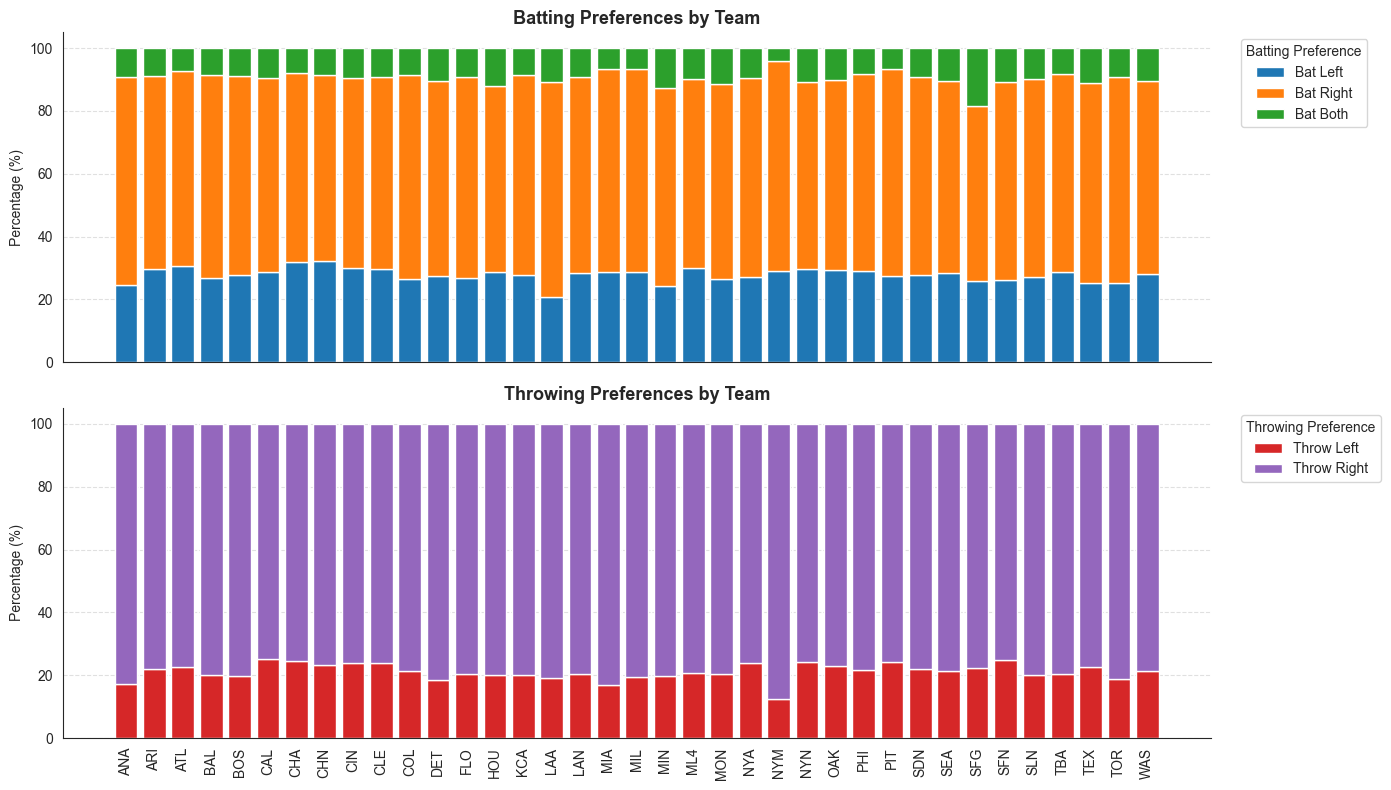

In [689]:
# Define colors
batting_colors = {
    'bat_left_pct': '#1f77b4',    # Blue
    'bat_right_pct': '#ff7f0e',   # Orange
    'bat_both_pct': '#2ca02c',    # Green
}

throwing_colors = {
    'throw_left_pct': '#d62728',  # Red
    'throw_right_pct': '#9467bd', # Purple
}

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# --- Batting preferences plot ---
bottom_vals = None
for col in batting_colors.keys():
    axes[0].bar(batting_df.index, batting_df[col], label=col.replace('_pct', '').replace('_', ' ').title(),
                bottom=bottom_vals, color=batting_colors[col])
    if bottom_vals is None:
        bottom_vals = batting_df[col]
    else:
        bottom_vals += batting_df[col]

axes[0].set_title('Batting Preferences by Team', fontweight='bold', fontsize=13)
axes[0].set_ylabel('Percentage (%)')
axes[0].legend(title='Batting Preference', bbox_to_anchor=(1.02, 1), loc='upper left')

# --- Throwing preferences plot ---
bottom_vals = None
for col in throwing_colors.keys():
    axes[1].bar(throwing_df.index, throwing_df[col], label=col.replace('_pct', '').replace('_', ' ').title(),
                bottom=bottom_vals, color=throwing_colors[col])
    if bottom_vals is None:
        bottom_vals = throwing_df[col]
    else:
        bottom_vals += throwing_df[col]

axes[1].set_title('Throwing Preferences by Team', fontweight='bold', fontsize=13)
axes[1].legend(title='Throwing Preference', bbox_to_anchor=(1.02, 1), loc='upper left')

# Adjust x-axis
for ax in axes:
    ax.set_xticklabels(throwing_df.index, rotation=90)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.set_ylabel('Percentage (%)')

plt.tight_layout()
plt.show()

Trend from the viz is quite obvious: most are right throwers and batters.

### 5.3 Height and Weight Trends Over Time
***SQL Query:***

```sql

***Query Result:***

In [736]:
query = """
WITH avg_hw AS (
	SELECT FLOOR(EXTRACT(YEAR FROM debut) / 10) * 10 AS decade, 
			ROUND(AVG(height)) AS avg_height_inches, ROUND(AVG(weight)) AS avg_weight_lbs
	FROM players
	GROUP BY FLOOR(EXTRACT(YEAR FROM debut) / 10) * 10)

SELECT  decade::INT, avg_height_inches,
		avg_height_inches - LAG(avg_height_inches) OVER (ORDER BY decade) AS height_diff,
		avg_weight_lbs,
		avg_weight_lbs - LAG(avg_weight_lbs) OVER (ORDER BY decade) AS weight_diff
FROM avg_hw
WHERE decade IS NOT NULL
ORDER BY decade;
"""

In [740]:
df_height_weight_stats = pd.read_sql_query(query, con=engine)
preview_table(df_height_weight_stats, "df_height_weight_stats")

**Preview of `df_height_weight_stats`:**

,decade,avg_height_inches,height_diff,avg_weight_lbs,weight_diff
0,1870,69.0,NaN,163.0,NaN
1,1880,70.0,1.0,169.0,6.0
...,...,...,...,...,...
13,2000,74.0,1.0,206.0,12.0
14,2010,74.0,0.0,207.0,1.0


In [774]:
df_summary_stats = df_height_weight_stats[['height_diff', 'weight_diff']].describe()
df_summary_stats.loc[['count', 'mean', '25%', '50%', '75%', 'min', 'max']]

,height_diff,weight_diff
count,14.000000,14.000000
mean,0.357143,3.142857
25%,0.000000,1.000000
50%,0.000000,2.000000
75%,1.000000,5.500000
min,0.000000,-2.000000
max,1.000000,12.000000


Average height differece (decade over decade) is not substantial (0.35 inches) with maximum difference 1 inch between any two decade. That tells us that height mostly stayed consistent (within 0 to +1lbs). However, weight difference is slightly more (average 3.14 lbs and 75% of the time, below or at 5.5lb decade over decade difference). It is as much as 12 lbs difference in the 2000s than the previous decade.

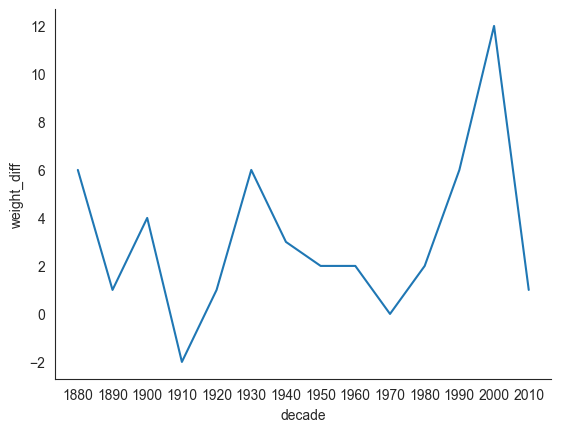

In [761]:
sns.lineplot(data=df_height_weight_stats, x='decade', y='weight_diff')
plt.xticks(range(1880, 2020, 10))

plt.show()

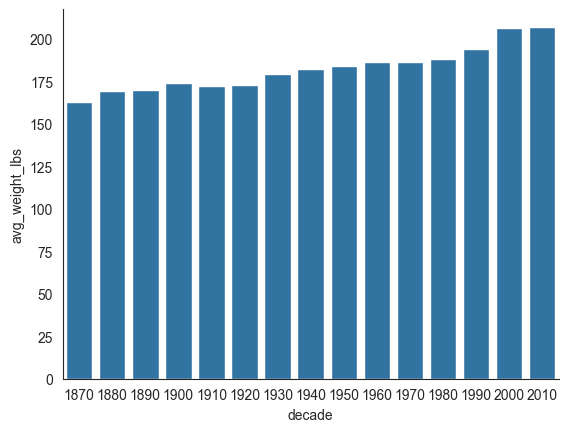

In [794]:
sns.barplot(data=df_height_weight_stats, x='decade', y='avg_weight_lbs')
# plt.xticks(range(1880, 2020, 10))

plt.show()

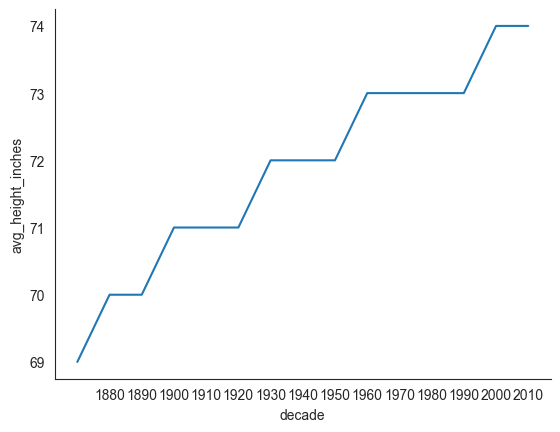

In [783]:
sns.lineplot(data=df_height_weight_stats, x='decade', y='avg_height_inches')
plt.xticks(range(1880, 2020, 10))

plt.show()

height is more of a gradual increase. It increases by 1 and stays consistent over a few decades and goes up, only going up by 1lb at a time if any. The overall, trend is upward from 1880 to 2010 but more gradual and steady with less fluctuations.

weight has peaks and declines (around 160lbs in 1880 to ~200lbs by 2010s). Notable peaks at 2000 (up by 12 lbs) and the movement is still up in 2010s but this time by 2 lbs increase.

## 4. Concluding Summary

Refactor Notes:
- Hide SQL Queries:
  
```
with open("top_spenders.sql") as f:
    query = f.read()

df_top_20_pct = pd.read_sql(query, con=engine)
display(df_top_20_pct)

```

- Visualization Enhancement and embedde insights into the Viz title: ggplot.
- Standardize quotes
- Refine Insights
- read_sql_query for using with WITH 